


# Imports

In [1]:
#imports 
import numpy as np
import scipy as sp
import sympy as sym
import quadpy as qp
import pandas as pd
import math as math
import mpmath as mp
from dateutil import parser
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numexpr
import lmfit
from astropy.io import fits
from astropy.stats import sigma_clip
import plotly.graph_objects as go
import os
import pymc3 as pm
import arviz as az
import corner
import tqdm
import dill
import time as time
sym.init_printing(use_latex='mathjax')
import IPython.display as disp
import pickle
import astropy




# Creating the symbolic probability density function

## Introduction

The main difference between the NSC method used in this document and the methods that already exist (Hanot, Defrere,…), is that it relies on the analytical description of the probability density function of the made observations. This first part shows how this description comes into being. 

The observed interferometric singal I(t) exists of a signal S(t) and normally distributed noise B(t). The signal S(t) can be described as

\begin{equation}
S(t)= I_{1}(t)+I_{2}(t)-2|V| \sqrt{I_{1}(t) I_{2}(t)} \cos (\Delta \phi(t))
\end{equation}

where $I_{1}(t)$ and $I_{2}(t)$ are different known signals of the two light beams, $\Delta(\phi(t))$ is the phasing error that represents the offset from the central dark fringe. According to (defrere), it is safe to assume that this offset is normally distributed with mean $\mu_{1}$ and variance $\sigma_{1}$. Also the noise $B(t)$ can assumed to be ~ N($\mu_{2}$,$\sigma_{2}$). In order to have $I(t)$ values between $[-1:1]$, it is scaled by an estimation of the expected constructive signal $I_{+}(t)$

\begin{equation}
I_{+}(t)= I_{1}(t)+I_{2}(t)+2 \sqrt{I_{1}(t)I_{2}(t)}
\end{equation}

Combining the above results, renders the following description of the interferometric signal

\begin{equation}
I(t)=\frac{I_{1}(t)+I_{2}(t)-2|V| \sqrt{I_{1}(t) I_{2}(t)} \cos (\Delta \phi(t))+B(t)}{I_{1}(t)+I_{2}(t)+2 \sqrt{I_{1}(t)I_{2}(t)}}
\end{equation}

As mentioned in (Defrere 2016) the equation above 'is only valid for instantaneous flux measurements or if the time-dependent quantities do not vary within each integration time. In the case of the LBTI, the instantaneous differential phase varies significantly at high frequency, which would require integration times prohibitively short to “freeze” it. While integration times as short as 3 ms could be used in practice, this would lead to a significant sensitivity loss due to readout noise and camera overheads. Therefore, we have modified the synthetic null depth expression to include the effect of varying differential phase over a finite integration time. The average of the flux at null over an integration time T can be expressed as'

\begin{equation}
I(t)=\frac{I_{1}+I_{2}-2|V| \sqrt{I_{1} I_{2}} \cos (\Delta \phi(t))\alpha+B}{I_{1}+I_{2}+2 \sqrt{I_{1}I_{2}}}
\end{equation}

where $I_{1}, I_{2}, B$ are the mean values of $I_{1}(t), I_{2}(t), B(t)$ and $\alpha = 1-0.5\epsilon^{2}$ with $\epsilon$ is the standard deviation over time T of the phase. It is measured in real time by PHASECam for the LBTI.

A description of the probability density function of $I(t)$ can be created with this information together with the use of the techniques of non-monotonic transformation of random variables http://cknudson.com/StudentWork/Transforms.pdf. We recommend to read this document as it is a good explanation of the technique used below. <br> It answers the question: If $\Delta(\phi(t))$ follows a N($\mu_{1}$,$\sigma_{1})$ and $B$ follows a N($\mu_{2}$,$\sigma_{2})$, what is then the distribution of $ I(t)$ ? We will do this in the code below by first finding the distribution of $\frac{S(t)}{I_{+}}$ and $\frac{B}{I_{+}}$, then we will add these two distributions by performing a convolution between them.

## PDF creation

The distribution of $y = g(x) = \frac{S(t)}{I_{+}}$ is $P_{y}$, with $x = \Delta(\phi(t))$ and $x \sim N(\mu_{1}$,$\sigma_{1}) = P_{x}$ is
\begin{equation}
P_{\mathrm{y}}(y)=\sum_{i=1}^{k} P_{\mathrm{x}}\left(g_{\mathrm{i}}^{-1}(y)\right)\left|\frac{d}{d y} g_{\mathrm{i}}^{-1}(y)\right| 
\end{equation}


The sum, in the above equation, refers to the montone parts of $g(x)$ i.e. if $g(x) = x^{2}$ it would have two montone parts over $(-\infty,0)$ and $(0,\infty)$. We calculate 

\begin{equation}
g_{\mathrm{1/2}}^{-1}(y) = \pm\arccos\left(\frac{S(t)I_{+}-I_{1}-I_{2}}{- 2|V|\alpha\sqrt{I_{1}I_{2}}}\right) = \pm\arccos\left(f(y)\right)
\end{equation} 
\begin{equation}
\frac{d}{d y} g_{\mathrm{1/2}}^{-1}(y) \quad = \pm\frac{-1}{\sqrt{1-f(y)^{2}}}f'(y)
\end{equation}
\begin{equation}
P_{\mathrm{x}} =\frac{1}{\sigma_{1} \sqrt{2 \pi}} e^{-\frac{1}{2}\left(\frac{x-\mu_{1}}{\sigma_{1}}\right)^{2}}
\end{equation}



These equations give us the necessary tools to create $P_{y}(y)$ the distribution of $\frac{S(t)}{I_{+}}$. This is done in the function $\textbf{Signal_sym()}$. Creating the probability distribution $P_{z}(z)$ of $z =  \frac{B}{I_{+}}$ is easier, since it is a linear transformation of $B$ ~ N($\mu_{2}$,$\sigma_{2}$). Therefore:

\begin{equation}
P_{z}(z) = N\left(\frac{\mu_{2}}{I_{+}},\frac{\sigma_{2}}{I_{+}}\right)
\end{equation}


This is created in the function $\textbf{Background_sym}()$. The final probability distribution of $I(t)$ is a convolution between these two distributions:

\begin{equation}
P_{I(t)}(t) = (P_{y} \ast P_{z})(t):=\int_{-\infty}^{\infty} P_{y}(\tau) P_{z}(t-\tau) d \tau 
\end{equation}

In our case the convolution bounds do not vary between $(-\infty,\infty)$, but are restricted by arccos(). The values within arccos() should be $[-1:1]$, so:

\begin{equation}
\frac{\tau T-I_{1}-I_{2}}{- 2|V|(1-0.5\epsilon^{2})\sqrt{I_{1}I_{2}}}\pm 1 = 0
\end{equation}

\begin{equation}
\frac{-2\sqrt{I_{1}I_{2}} V \alpha + I_{1} + I_{2}}{2\sqrt{I_{1}I_{2}} + I_{1} + I_{2}} < \tau < \frac{2\sqrt{I_{1}I_{2}} V \alpha + I_{1} + I_{2}}{2\sqrt{I_{1}I_{2}} + I_{1} + I_{2}}
\end{equation}

Unfortunately Sympy cannot calculate this integral. The following pieces of code calculate what is described above, with at the end $\textbf{B_sym, S_sym, Int_sym}$ the symbolic representation of respectively  $P_{z}, P_{y} \text{ and } P_{I(t)}$. The entire workflow of this notebook would be greatly improved if an analytical solution of the convolution integral could be calculate. Now, we will have to resort on numerical approximations. 

In [2]:
# First we create all necessary symbolic variables that will be needed in this Notebook.

bins_sym= sym.Symbol('x',real=True) # Bin-value of the histogram of I(t)
N_sym = sym.Symbol('N',real=True) # Null
V_sym = (1-N_sym)/(1+N_sym) # Visibility

mu1_sym = sym.Symbol('mu1',real=True,positive=True,nonzero=True) # Mean of the phasing error
sigma1_sym = sym.Symbol('sigma1',real=True,positive=True,nonzero=True) # Standard deviation of the phasing error

mu2_sym = sym.Symbol('mu2',real=True,positive=True,nonzero=True) # Mean of the background noise
sigma2_sym = sym.Symbol('sigma2',real=True,positive=True,nonzero=True) # Standard deviation of the background noise

I1_sym = sym.Symbol('I1',real=True,positive=True,nonzero=True) # Beam intensity of I1(t)
I2_sym = sym.Symbol('I2',real=True,positive=True,nonzero=True) # Beam intensity of I2(t)

alpha_sym = sym.Symbol('alpha',real=True,positive=True,nonzero=True) # Synthetic null depth expression 
                                            
scale_factor_sym = I1_sym+I2_sym+2*sym.sqrt(I1_sym*I2_sym)# Symbolic expression of the expected constructive signal. 

tau_sym = sym.Symbol('tau', real=True,positive=True)# Symbolic value that will be needed
                                                    # later to perform a convolution between two distributions.


In [3]:
from sympy import oo, Symbol
from scipy import signal
from sympy import convolution
from sympy import fourier_transform

def gaussian1D_sym(x, mu, sig):
    return sym.exp(-(x-mu)**2/(2*sig**2)-sym.ln(2*sym.pi*sig**2)/2)

def convolve(f, g, t, lower_limit, upper_limit):
    integrand = f.subs(t,tau_sym) * g.subs(t, t-tau_sym)
    return integrand

def Signal_sym(bins,V,mu1,sigma1,mu2,sigma2,I1,I2,alp):
        
    teller1 = bins*scale_factor_sym - (I1+I2)
    noemer1 = -2*V*sym.sqrt(I1*I2)*alp
    g_inv = sym.acos(teller1/noemer1)

    g_inv_diff = sym.diff(g_inv,bins)
    Signal =  sym.Abs(g_inv_diff)*(gaussian1D_sym(g_inv,mu1,sigma1) + gaussian1D_sym(-g_inv,mu1,sigma1))
        
    return Signal

def Background_sym(bins,V,mu1,sigma1,mu2,sigma2,I1,I2,alp):
    
    Background = gaussian1D_sym(bins,(1/scale_factor_sym)*mu2,sigma2*(1/scale_factor_sym))

    return Background


def Interferometric_sym(bins,V,mu1,sigma1,mu2,sigma2,I1,I2,alp):
    
    S = Signal_sym(bins,V,mu1,sigma1,mu2,sigma2,I1,I2,alp)

    B = Background_sym(bins,V,mu1,sigma1,mu2,sigma2,I1,I2,alp)    
    
    tau_min = (-2*sym.sqrt(I1)*sym.sqrt(I2)*V*alp + I1 + I2)/(2*sym.sqrt(I1)*sym.sqrt(I2) + I1 + I2)
    tau_max = (2*sym.sqrt(I1)*sym.sqrt(I2)*V*alp + I1 + I2)/(2*sym.sqrt(I1)*sym.sqrt(I2) + I1 + I2)

    I = convolve(S,B,bins,tau_min,tau_max)
    return S,B,I

In [4]:
[S_sym,B_sym,Int_sym_raw] = Interferometric_sym(bins_sym,V_sym,mu1_sym,sigma1_sym,mu2_sym,sigma2_sym,I1_sym,I2_sym,alpha_sym)

In [5]:
B_sym

                                                                  2           
                                 ⎛              μ₂               ⎞  ⎛    ____ 
                                -⎜- ───────────────────────── + x⎟ ⋅⎝2⋅╲╱ I₁ ⋅
                                 ⎜      ____   ____              ⎟            
                                 ⎝  2⋅╲╱ I₁ ⋅╲╱ I₂  + I₁ + I₂    ⎠            
                                ──────────────────────────────────────────────
                                                                  2           
   ⎛    ____   ____          ⎞                                2⋅σ₂            
√2⋅⎝2⋅╲╱ I₁ ⋅╲╱ I₂  + I₁ + I₂⎠⋅ℯ                                              
──────────────────────────────────────────────────────────────────────────────
                                             2⋅√π⋅σ₂                          

                 2 
  ____          ⎞  
╲╱ I₂  + I₁ + I₂⎠  
                   
                   
───────────────────
          

In [6]:
S_sym

⎛                                                                       2     
⎜     ⎛          ⎛         ⎛             ⎛    ____   ____          ⎞⎞ ⎞⎞      
⎜     ⎜          ⎜-(N + 1)⋅⎝-I₁ - I₂ + x⋅⎝2⋅╲╱ I₁ ⋅╲╱ I₂  + I₁ + I₂⎠⎠ ⎟⎟      
⎜    -⎜-μ₁ + acos⎜────────────────────────────────────────────────────⎟⎟      
⎜     ⎜          ⎜                 ____   ____                        ⎟⎟      
⎜     ⎝          ⎝             2⋅╲╱ I₁ ⋅╲╱ I₂ ⋅α⋅(1 - N)              ⎠⎠      
⎜    ─────────────────────────────────────────────────────────────────────    
⎜                                        2                                    
⎜                                    2⋅σ₁                                     
⎜√2⋅ℯ                                                                        √
⎜───────────────────────────────────────────────────────────────────────── + ─
⎝                                 2⋅√π⋅σ₁                                     
────────────────────────────────────────────────────

In [7]:
Int_sym_raw

   ⎛                                                                       2  
   ⎜     ⎛          ⎛         ⎛             ⎛    ____   ____          ⎞⎞ ⎞⎞   
   ⎜     ⎜          ⎜-(N + 1)⋅⎝-I₁ - I₂ + τ⋅⎝2⋅╲╱ I₁ ⋅╲╱ I₂  + I₁ + I₂⎠⎠ ⎟⎟   
   ⎜    -⎜-μ₁ + acos⎜────────────────────────────────────────────────────⎟⎟   
   ⎜     ⎜          ⎜                 ____   ____                        ⎟⎟   
   ⎜     ⎝          ⎝             2⋅╲╱ I₁ ⋅╲╱ I₂ ⋅α⋅(1 - N)              ⎠⎠   
   ⎜    ───────────────────────────────────────────────────────────────────── 
   ⎜                                        2                                 
   ⎜                                    2⋅σ₁                                  
   ⎜√2⋅ℯ                                                                      
√2⋅⎜───────────────────────────────────────────────────────────────────────── 
   ⎝                                 2⋅√π⋅σ₁                                  
────────────────────────────────────────────────────

So the above equation shows the integrand that we want to solve. Note that in the code above we already replaced $V$ with $\frac{1-N}{1+N}$. 

## Test on synthetic data

To test these symbolic descriptions, we create a synthetic data set and verify if indeed the equation matches the contour of the histogram. We determine the values of the parameters and generate a synthetic background and phasing error.

In [8]:
# Describe variables - values the same as in this paper: https://www.researchgate.net/publication/305869884_Making_high_accuracy_null_depth_measurements_for_the_LBTI_Exozodi_survey 

I1_true = 5.0  
I2_true = I1_true-0.01*I1_true

V_true = 0.996
N_true = (1-V_true)/(1+V_true)
alp_true = 1-0.5*0.21**2
scale_factor = I1_true+I2_true+2*np.sqrt(I1_true*I2_true)

mu1_true = 0.075
sigma1_true = 0.075
mu2_true = 0.01
sigma2_true = 0.01

numbsamples = 10**4 
numbins = 100
 
offset = np.random.normal(mu1_true,sigma1_true,numbsamples)
B = np.random.normal(mu2_true,sigma2_true,numbsamples)

plot background and phasing error

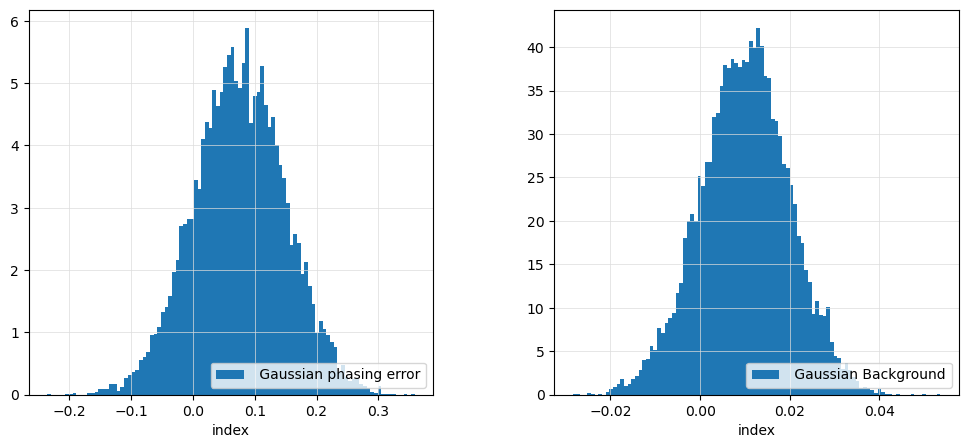

In [9]:
fig, ax = plt.subplots(1, 2,figsize=(12,5))
plt.subplots_adjust(wspace=0.3, hspace=0.2)
index = list(range(0,offset.shape[0]))

ax[0].hist(offset,  bins=numbins,density=True, label=" Gaussian phasing error")
# ax.hist(B,bins=numbins,density=True, label= "Gaussian background noise")
ax[0].set_xlabel("index")
ax[0].grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
ax[0].legend(loc=4)

ax[1].hist(B,  bins=numbins,density=True, label=" Gaussian Background")
# ax.hist(B,bins=numbins,density=True, label= "Gaussian background noise")
ax[1].set_xlabel("index")
ax[1].grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
ax[1].legend(loc=4)

plt.show()

The next piece of code generates the synthetic iterferometric signal, with the pre-determined parameter values. 

In [10]:
def I_gen(mu1,sigma1,mu2,sigma2,V,I1,I2,alp):
    
    '''
    Returns the interferomtric signal I, the background B and the signal S, 
    with the pre-determined parameter values. It turns them into histograms 
    and calculates the bin centers.
    '''
    I = I1+I2-2*np.abs(V)*alp*np.sqrt(I1*I2)*np.cos(offset) + B
    
    scale_factor = I1+I2+2*np.sqrt(I1*I2)

    I_norm = I/scale_factor
    B_norm = B/scale_factor
    S_norm = I_norm -  B_norm
    
    [I_norm_hist,I_norm_hist_bins] = np.histogram(I_norm, bins=numbins,density=True) 
    I_norm_hist_bins_centers = 0.5*(I_norm_hist_bins[1:] + I_norm_hist_bins[:-1])
    
    [B_norm_hist,B_norm_hist_bins] = np.histogram(B_norm, bins=numbins,density=True)
    B_norm_hist_bins_centers = 0.5*(B_norm_hist_bins[1:] + B_norm_hist_bins[:-1])
    
    [S_norm_hist,S_norm_hist_bins] = np.histogram(S_norm, bins=numbins,density=True)
    S_norm_hist_bins_centers = 0.5*(S_norm_hist_bins[1:] + S_norm_hist_bins[:-1])
    
    return [I_norm,I_norm_hist,I_norm_hist_bins_centers,
           B_norm,B_norm_hist,B_norm_hist_bins_centers,
           S_norm,S_norm_hist,S_norm_hist_bins_centers]




In [11]:
[I_norm_gen,I_norm_hist_gen,I_norm_hist_bins_centers_gen,
 B_norm_gen,B_norm_hist_gen,B_norm_hist_bins_centers_gen, 
 S_norm_gen,S_norm_hist_gen,S_norm_hist_bins_centers_gen] = I_gen(mu1_true,sigma1_true,mu2_true,sigma2_true
                                                      ,V_true,I1_true,I2_true,alp_true)

We create a lambda function of our $\textbf{S_sym}$ and $\textbf{B_sym}$ equation, so that we can evaluate them at every bin center

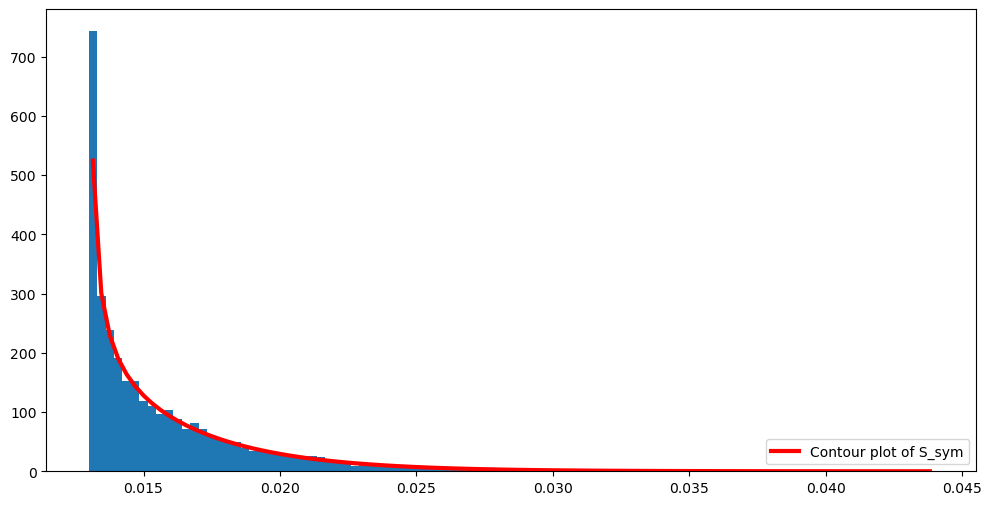

In [12]:
#visualize Signal
S_lambd = sym.utilities.lambdify([bins_sym,N_sym,mu1_sym,sigma1_sym,
                                  mu2_sym,sigma2_sym,I1_sym,I2_sym,alpha_sym],S_sym)

signal_values = []
for i in S_norm_hist_bins_centers_gen:
    a = S_lambd(i,N_true, mu1_true, sigma1_true,mu2_true,
                sigma2_true,I1_true,I2_true,alp_true)
    signal_values = np.append(signal_values,a)

fig, ax = plt.subplots(1,1, figsize=(12,6))

ax.hist(S_norm_gen, bins = numbins,density=True,zorder=-1)
ax.plot(S_norm_hist_bins_centers_gen,signal_values, color = 'red',
        label = 'Contour plot of S_sym',linewidth = 3)
ax.legend(loc = 4)

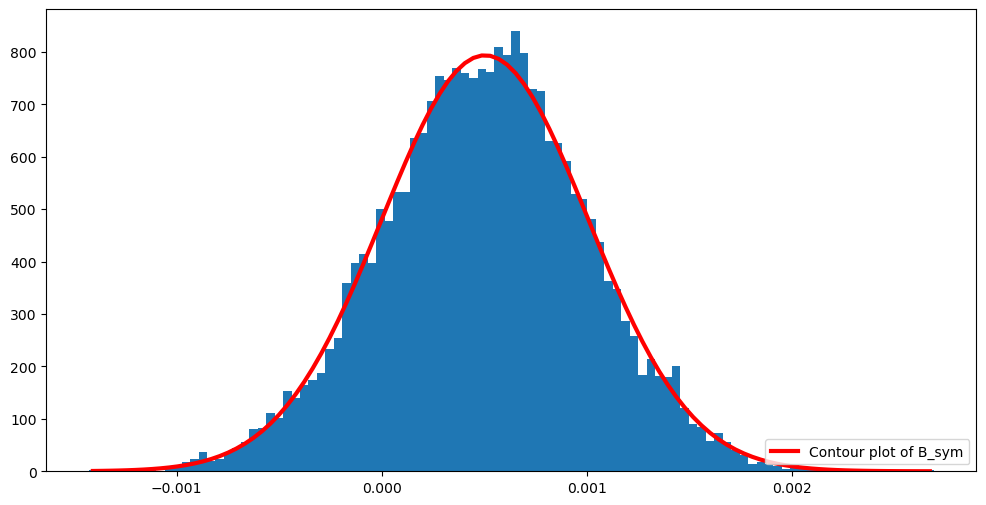

In [13]:
#visualize Background
B_lambd = sym.utilities.lambdify([bins_sym,N_sym,mu1_sym,sigma1_sym,
                                  mu2_sym,sigma2_sym,I1_sym,I2_sym,alpha_sym],B_sym)

background_values = []
for i in B_norm_hist_bins_centers_gen:
    a = B_lambd(i,N_true, mu1_true, sigma1_true , mu2_true,
                sigma2_true,I1_true,I2_true,alp_true)
    background_values = np.append(background_values,a)

fig, ax = plt.subplots(1,1, figsize=(12,6))

ax.hist(B_norm_gen, bins = numbins,density=True,zorder=-1)
ax.plot(B_norm_hist_bins_centers_gen,background_values, color = 'red',
        label = 'Contour plot of B_sym',linewidth = 3)
ax.legend(loc = 4)

Both the contours follow the histogram well, which renders us to believe that $\textbf{S_sym}$ and $\textbf{B_sym}$ are the correct equations. For $\textbf{Int_sym}$, which is the integrand that is going to be fit in the end, it gets more complicated, due to numerical instablities. First we fill in as much as known values outside of the integral, and simplify the equation in such a way that most of the values are in the exponential value. This results in more numerical stabillity. 

In [14]:
def Fill_in_known(Int_sym_raw,alpha,I1,I2,mu2,sigma2):
    '''
    Evaluates the knwon parameters in our integrand.
    It returns the evaluated integrand and the bounds 
    over which the integral is evaluated. 
    '''
    # Fill in knwon values and simplify equation.
    Int_sym = sym.powsimp(sym.expand(sym.simplify(Int_sym_raw.subs(alpha_sym,alpha).subs(I1_sym,I1)
                                              .subs(I2_sym,I2).subs(mu2_sym,mu2).subs(sigma2_sym,sigma2))))
    # Write everything in the exp() form.
    getal = sym.ln(np.prod(Int_sym.args[0].args[0:5]))
    with sym.evaluate(False):
        Int_sym = (sym.exp(Int_sym.args[0].args[5].args[0]+getal) + 
                   sym.exp(Int_sym.args[1].args[5].args[0]+getal))
    
    # Create lambda function of the integrand and of the bounds. 
    Int_lambd= sym.utilities.lambdify([tau_sym,bins_sym,N_sym,mu1_sym,sigma1_sym],Int_sym,'sympy')
    tau_max_lambd = sym.utilities.lambdify([N_sym],(2*sym.sqrt(I1)*sym.sqrt(I2)*V_sym*alpha + I1 + I2)/
                                           (2*sym.sqrt(I1)*sym.sqrt(I2) + I1 + I2),'numpy')
    tau_min_lambd = sym.utilities.lambdify([N_sym],(-2*sym.sqrt(I1)*sym.sqrt(I2)*V_sym*alpha + I1 + I2)/
                                           (2*sym.sqrt(I1)*sym.sqrt(I2) + I1 + I2),'numpy')
    
    return Int_lambd,tau_max_lambd,tau_min_lambd

In [15]:
def Int_func_wrong(bins,N,mu1,sigma1):
    """
    This function evaluates the integrand value over the entire 
    bound of tau for each bin value. 
    It uses a Scipy integration method to do this.
    """
    #Define bounds of integral
    tau_min = float(tau_min_lambd(N))
    tau_max = float(tau_max_lambd(N))
    
    #Evaluate values that are not in the integral.
    with sym.evaluate(False):    
        Int_lambd2 = Int_lambd(tau_sym, bins_sym, N, mu1, sigma1)
        
    #Create lambda function
    Int_lambd3 = sym.utilities.lambdify((tau_sym,bins_sym), Int_lambd2, modules = 'numpy')
        
    #Evaluate integral    
    result = []    
    for i in bins:
        a, b = sp.integrate.quad(Int_lambd3, tau_min, tau_max, args=(i,))
        
        result = np.append(result,a)
        

    return result

totaal: 1.3242127895355225


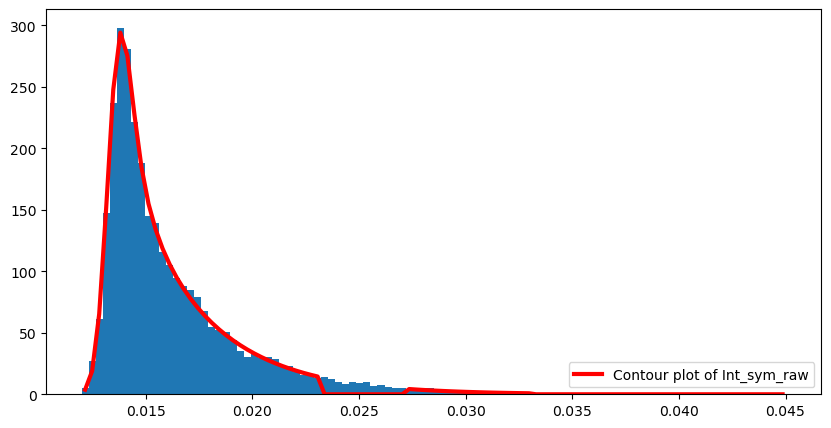

In [16]:
import warnings
warnings.filterwarnings("ignore")

start_time = time.time() 
Int_lambd, tau_max_lambd,tau_min_lambd = Fill_in_known(Int_sym_raw,alp_true,I1_true,I2_true,mu2_true,sigma2_true)
values = Int_func_wrong(I_norm_hist_bins_centers_gen,N_true, mu1_true, sigma1_true)
                
print('totaal:', time.time() - start_time)

fig, ax = plt.subplots(1,1, figsize=(10,5))

ax.hist(I_norm_gen, bins = numbins,density=True,zorder=-1)
ax.plot(I_norm_hist_bins_centers_gen,values, color = 'red', 
        label = 'Contour plot of Int_sym_raw',linewidth = 3)
ax.legend(loc=4)

The contour plot follows the histogram well, except at selected places were it suddenly drops to zero. This is caused by two reasons:
- The bounds of the integral are two large
- The scipy integration is not precise enough

We demonstrate the bounds problem below. By evalutating the integrand over the domain of the integral of $\tau$ at one bin value i.e. $0.025$

In [17]:
tau_min = tau_min_lambd(N_true)
tau_max = tau_max_lambd(N_true)
taus = np.linspace(tau_min,tau_max,200)

Int_sym_test = Int_sym_raw.subs(alpha_sym,alp_true).subs(I1_sym,I1_true).subs(I2_sym,I2_true).subs(mu2_sym,mu2_true).subs(sigma2_sym,sigma2_true).subs(N_sym,N_true).subs(mu1_sym,mu1_true).subs(sigma1_sym,sigma1_true).subs(bins_sym,0.025)

result = []
for i in taus:
    result = np.append(result, np.real(Int_sym_test.subs(tau_sym,i)))

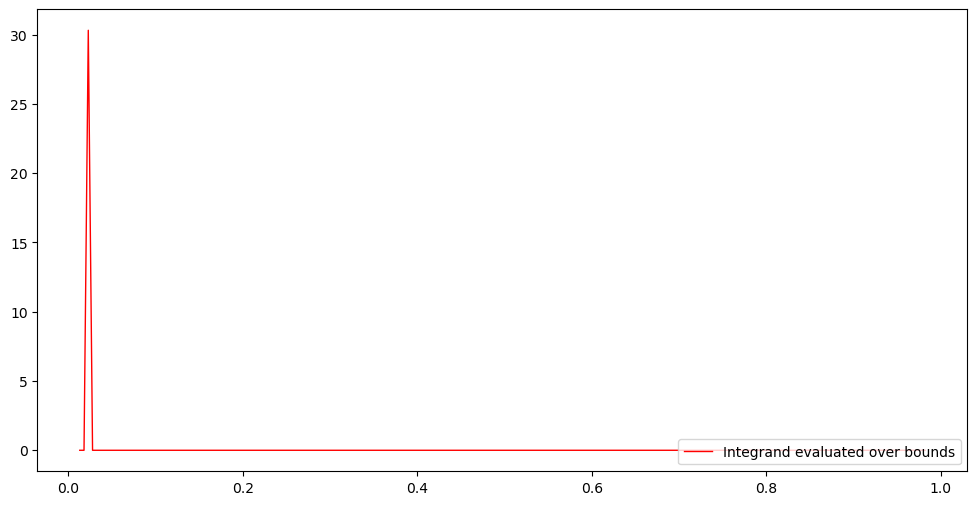

In [18]:
fig, ax = plt.subplots(1,1, figsize=(12,6))

ax.plot(taus[:-1],result[:-1], color = 'red', label = 'Integrand evaluated over bounds',linewidth = 1)
ax.legend(loc = 4)

The figure above shows that the integral domain is to broad and that the values are located on a small section. We find an alternative upperbound. This is done due to the fact that the end of where the integral has non-zero value is close to the maximum bin value. So, we use 1.5 times the max_bin value as new upper bound. On top of that we add a backup when the scipy integral solver is not precise enough and returns NaN. In that case we use a mpmath integral solver. This is more precise, but is much slower. So, we only want to use this in the case that the scipy solver is not precise enough. 

First we plot the integral with the new upper bound. 

In [19]:
tau_min = tau_min_lambd(N_true)
# tau_max = tau_max_lambd(N_true)
tau_max = np.max(I_norm_hist_bins_centers_gen)
taus = np.linspace(tau_min,tau_max,200)

Int_sym_test = Int_sym_raw.subs(alpha_sym,alp_true).subs(I1_sym,I1_true).subs(I2_sym,I2_true).subs(mu2_sym,mu2_true).subs(sigma2_sym,sigma2_true).subs(N_sym,N_true).subs(mu1_sym,mu1_true).subs(sigma1_sym,sigma1_true).subs(bins_sym,0.025)

result = []
for i in taus:
    result = np.append(result, np.real(Int_sym_test.subs(tau_sym,i)))

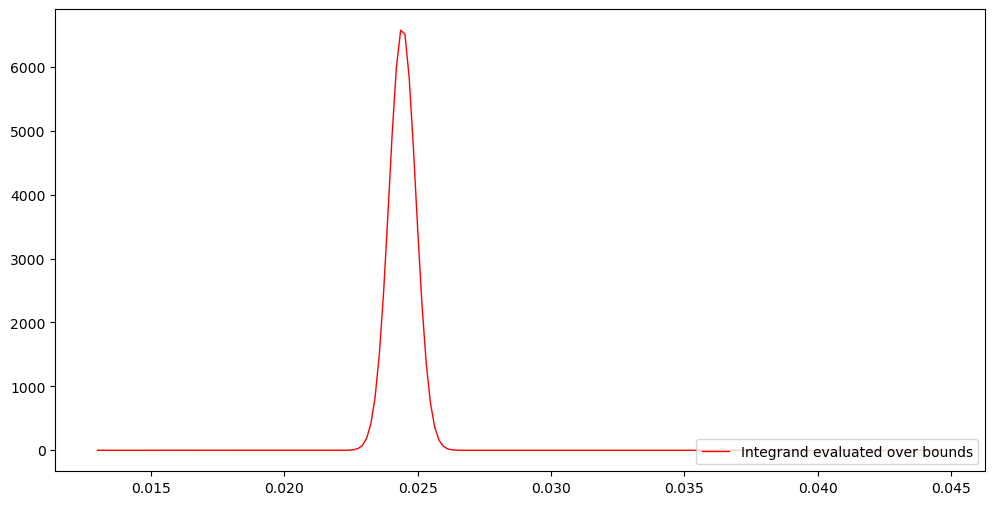

In [20]:
fig, ax = plt.subplots(1,1, figsize=(12,6))

ax.plot(taus[:-1],result[:-1], color = 'red', label = 'Integrand evaluated over bounds',linewidth = 1)
ax.legend(loc = 4)

This looks like a better domain to caculate our integral over. Now we also implement the mpmath solver. If this solver is also not able to find a result we return 0.

In [21]:
def Int_func(bins,N,mu1,sigma1):
    
    """
    This function evaluates the integrand value over
    an adapted bound of tau for each bin value. 
    It uses a Scipy integration method to do this,
    and has a backup Mpmath integration method for more
    precision. 
    """
        
    #Define bounds of integral
    tau_min = float(tau_min_lambd(N))
    tau_max = float(tau_max_lambd(N))
    up = min(tau_max,float(1.5*max(bins)))
    
    #Evaluate values that are not in the integral.
    with sym.evaluate(False):    
        Int_lambd2 = Int_lambd(tau_sym, bins_sym, N, mu1, sigma1)
        
    #Create lambda function
    Int_lambd3 = sym.utilities.lambdify((tau_sym,bins_sym), Int_lambd2, modules = 'numpy')
    Int_lambd4 = sym.utilities.lambdify((tau_sym,bins_sym), Int_lambd2, modules = 'sympy')
    
    #Evaluate integral        
    result = []
    for i in bins:
        a, b = sp.integrate.quad(Int_lambd3, tau_min, up, args=(i,))

        if np.isnan(a) or np.isinf(a):
            Int_lambd5 = sym.utilities.lambdify((tau_sym), Int_lambd4(tau_sym,i), modules = 'mpmath')
            a = float(mp.re(mp.quad(Int_lambd5, [tau_min, up])))  
        
        if np.isnan(a):
            a = 0
            
        result = np.append(result,a)
        

    return result

totaal: 0.38429856300354004


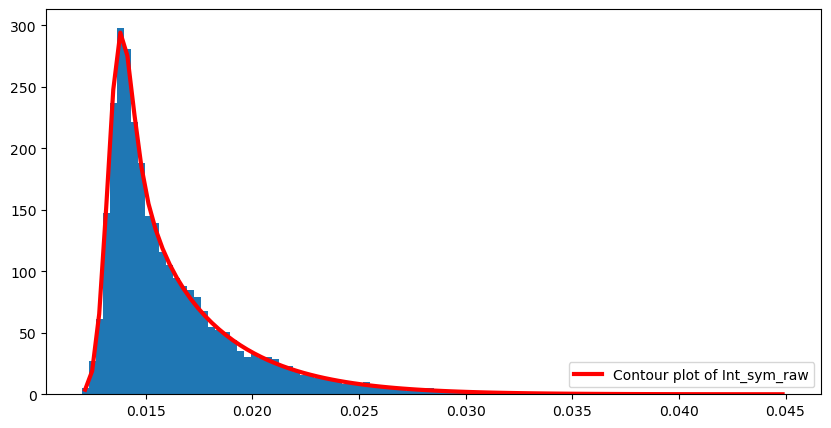

In [22]:
import warnings
warnings.filterwarnings("ignore")
Int_lambd, taux_max_lambd,tau_min_lambd = Fill_in_known(Int_sym_raw,alp_true,I1_true,I2_true,mu2_true,sigma2_true)

start_time = time.time() 
values = Int_func(I_norm_hist_bins_centers_gen,N_true, mu1_true, sigma1_true)
                
print('totaal:', time.time() - start_time)

fig, ax = plt.subplots(1,1, figsize=(10,5))

ax.hist(I_norm_gen, bins = numbins,density=True,zorder=-1)
ax.plot(I_norm_hist_bins_centers_gen,values, color = 'red', label = 'Contour plot of Int_sym_raw',linewidth = 3)
ax.legend(loc=4)

The integral follows the distribution of the data well. In the next part this method will be applied to real data. How fast this integral is solved will become the most crucial part in this code.

# Fitting the probability density function to histogram of real data

The equation $\textbf{Int_sym_raw}$ represents the contour of the histogram of the data. The goal is to tweak all the variables in this function in order for the contour to fit the histogram of the data 'as good as possible'. 

We preprocess the data with the function $\textbf{preprocess()}$:
- uploads an observation file
- trims the interferometric signal (the Null data) by using a sigma-clipping method
  and normalizes it with the scale_factor
- creates a historgram from the data and calcuates the errobars on the histogram data points,
  by assuming Binomial error bars. 


In [23]:
def create_variance(I_norm_hist):
    
    """
    Return Binomial distributed error bars. 
    """
    
    n = np.sum(I_norm_hist)
    p = I_norm_hist/n
    
    #binomial
    sigma = np.sqrt(n*p*(1-p)) 
    
    # An added value in order to have no error bars equal to zero
    plus = np.partition(np.unique(sigma), 1)[1] 
    sigma = sigma + plus
    
    return sigma

In [24]:
def freedman_diaconis(data, returnas="bins"):
    """
    Use Freedman Diaconis rule to compute optimal histogram bin width. 
    ``returnas`` can be one of "width" or "bins", indicating whether
    the bin width or number of bins should be returned respectively. 
    """
    data = np.asarray(data, dtype=np.float_)
    IQR  = sp.stats.iqr(data, rng=(25, 75), scale="raw", nan_policy="omit")
    N    = data.size
    bw   = (2 * IQR) / np.power(N, 1/3)

    if returnas=="width":
        result = bw
    else:
        datmin, datmax = data.min(), data.max()
        datrng = datmax - datmin
        result = int((datrng / bw) + 1)
    return(result)

In [25]:
def preprocess(ID):
    """
    Retrieves data from files. Removes outliers with sigma clipping,
    and normalizes it. 
    Returns histogram with errorbars of normalized and trimmed data. 
    """
    
    #CHOOSE DATA, name of data file
    os.chdir('/lhome/simon/Documents/Nulling/data_easy_name') 
    BCKG = astropy.io.fits.open('BCKG_' + str(ID) + ".fits")
    NULL = astropy.io.fits.open('NULL_' + str(ID) + ".fits")
    PHOT1 = astropy.io.fits.open('PHOT1_' + str(ID) + ".fits")
    PHOT2 = astropy.io.fits.open('PHOT2_' + str(ID) +  ".fits")
    
    os.chdir('/lhome/simon/Documents/Nulling') 
    
    I1_raw = PHOT1[1].data['FLX_TOT'][:,2] # First observed beam intensity
    I2_raw = PHOT2[1].data['FLX_TOT'][:,2] # Second observed beam intensity
    B_raw = BCKG[1].data['FLX_TOT'][:,2]       # measured background
    I_raw = NULL[1].data['FLX_TOT'][:,2]   # measured interferometric signal
    
    # measured alpha value. This value needs to be rewritten for a 2.2 microns wavelength and 
    # 11.1 microns scientific instrument wavelength.
    PCPHSTD = np.radians(NULL[1].data['PCPHSTD'])*(2.2/11.1) 
    alpha = float(np.mean(1-0.5*PCPHSTD**2))
    
    if B_raw.size > 990:
        sigma2 = (np.sqrt(np.var(B_raw[:990]))+np.sqrt(np.var(B_raw[990:])))/2
    else:
        sigma2 = np.sqrt(np.var(B_raw[:990]))
        
    #trim data using sigma clipping
    I = sigma_clip(I_raw, sigma=3,masked=False,axis=None).data

    #calculate number bins and data
    numb_data = I.shape[0]
    # numbins = int(np.round(np.sqrt(numb_data)))
    numbins = freedman_diaconis(I)

    I2_mean =  np.mean(I2_raw)
    I1_mean = np.mean(I1_raw)

    #scale data
    scale_factor = I1_mean+I2_mean+2*np.sqrt(I1_mean*I2_mean)
    I_norm = I/scale_factor
    B_norm = B/scale_factor
    
    #create histograms
    [I_norm_hist,I_norm_hist_bins] = np.histogram(I_norm, bins=numbins,density=True) 
    I_norm_hist_bins_centers = 0.5*(I_norm_hist_bins[1:] + I_norm_hist_bins[:-1])
    
    # calculate variance on histogram
    I_norm_sigma = create_variance(I_norm_hist)
    
    return I_norm,numbins,I_norm_hist_bins_centers,I_norm_hist,I_norm_sigma,alpha,I1_mean,I2_mean,sigma2


## Interferometric data $I$

The histogram of this data set is the one around which we will fit our contour. Error bars that follow a binomial distribution are added. 

In [26]:
I_norm,numbins,I_norm_hist_bins_centers,I_norm_hist,I_norm_sigma,alpha,I1_mean,I2_mean,sigma2 = preprocess(11)

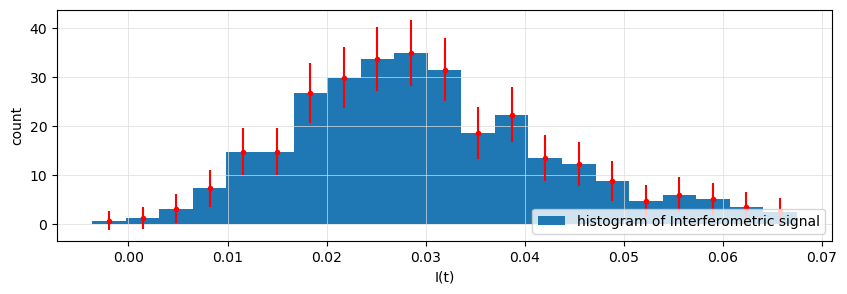

In [27]:
fig, ax = plt.subplots(1,1, figsize=(10,3))

ax.hist(I_norm, bins=numbins,density=True,label="histogram of Interferometric signal")
ax.errorbar(I_norm_hist_bins_centers, I_norm_hist, yerr=I_norm_sigma, fmt='.',color='red')
ax.set_xlabel("I(t)")
ax.set_ylabel("count")
ax.legend(loc=4)

ax.set_facecolor('white')
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)

plt.show()


## Photometric beams $I_{1}$ and $I_{2}$

The plots below and the Shapiro-Wilk test prove that $I_{1}$ and $I_{2}$ are both normally distributed. We will use the mean of these values in $\textbf{Int_sym}$.

In [28]:
#Upload data to plot raw data files.
os.chdir('/lhome/simon/Documents/Nulling/data_easy_name') 
BCKG = astropy.io.fits.open('BCKG_' + str(11) + ".fits")
NULL = astropy.io.fits.open('NULL_' + str(11) + ".fits")
PHOT1 = astropy.io.fits.open('PHOT1_' + str(11) + ".fits")
PHOT2 = astropy.io.fits.open('PHOT2_' + str(11) +  ".fits")

os.chdir('/lhome/simon/Documents/Nulling') 

I1_raw = PHOT1[1].data['FLX_TOT'][:,2] # First observed beam intensity
I2_raw = PHOT2[1].data['FLX_TOT'][:,2] # Second observed beam intensity
B_raw = BCKG[1].data['FLX_TOT'][:,2]       # measured background
I_raw = NULL[1].data['FLX_TOT'][:,2]   # measured interferometric signal

Shapiro-Wilk test I1: ShapiroResult(statistic=0.9983885884284973, pvalue=0.5031253099441528)
Shapiro-Wilk test I2: ShapiroResult(statistic=0.9976158738136292, pvalue=0.16817054152488708)


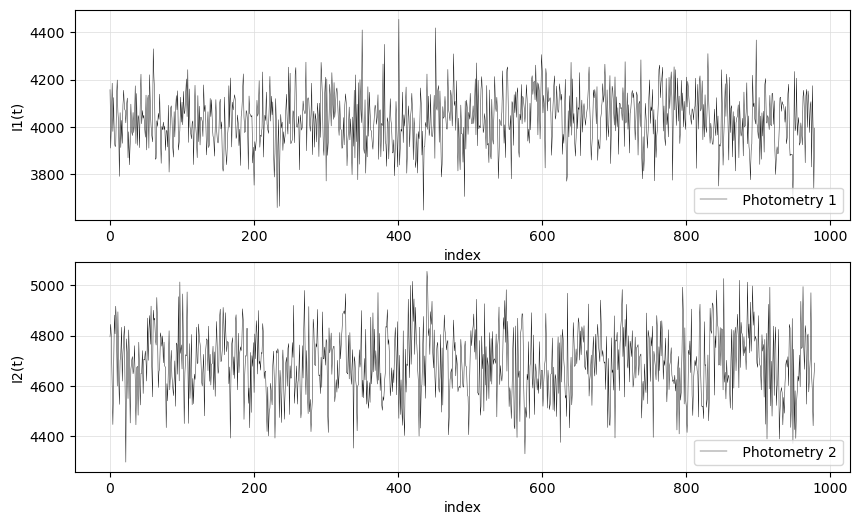

In [29]:
fig, ax = plt.subplots(2,1, figsize=(10,6))

index = list(range(0,I1_raw.shape[0]))

print('Shapiro-Wilk test I1:',sp.stats.shapiro(I1_raw))

ax[0].plot(index, I1_raw,color = 'black', linewidth=0.3, alpha=1., label=" Photometry 1")
ax[0].set_xlabel("index")
ax[0].set_ylabel("I1(t)")
ax[0].grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
ax[0].legend(loc=4)

index = list(range(0,I2_raw.shape[0]))

print('Shapiro-Wilk test I2:', sp.stats.shapiro(I2_raw))

ax[1].plot(index, I2_raw,color = 'black', linewidth=0.3, alpha=1., label=" Photometry 2")
ax[1].set_xlabel("index")
ax[1].set_ylabel("I2(t)")
ax[1].grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
ax[1].legend(loc=4)

plt.show()


As an interseting addition, we run an MCMC algorithm on $I_{1}$ (the same could be done for $I_{2}$) in order to get an idea of the posterior distributions of the mean and variance of the normally distributed photometric beam.

In [30]:
with pm.Model() as myModel:
    
    check = I1_raw
    # check = I2_raw
    
    # define priors
    mu = pm.Uniform('mu', lower=min(check), upper=max(check))
    sigma = pm.Uniform('sigma', lower=0, upper=np.abs(np.quantile(check,0.95) - np.quantile(check,0.05)))

    # define likelihood
    y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=check)

    trace = pm.sample(4000, chains=4, cores=4,target_accept = 0.95 ,return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 5 seconds.


In [31]:
az.summary(trace, var_names=['mu', 'sigma'], hdi_prob=0.95, round_to=5)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,4033.41699,3.80277,4026.12318,4041.03292,0.03654,0.02584,10835.85343,9157.27356,1.00032
sigma,116.03310,2.66321,110.92474,121.28202,0.02842,0.02010,8786.03318,8703.28569,1.00054


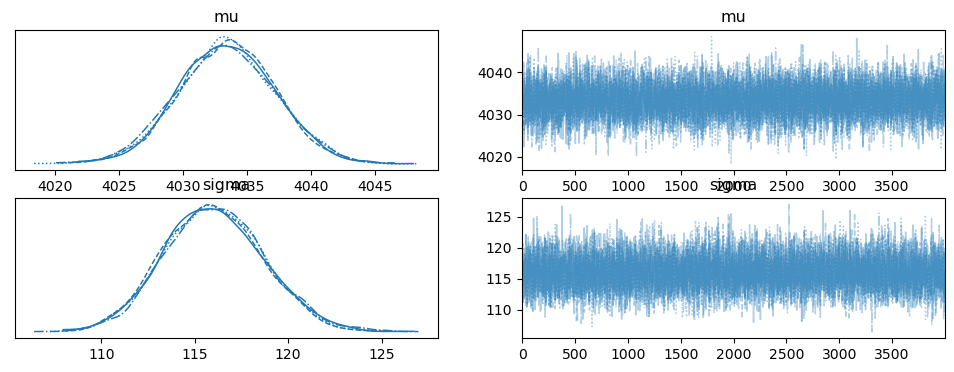

In [32]:
ax = az.plot_trace(trace, var_names=['mu','sigma'])

## Background $B$ with $\mu_{2}$ and $\sigma_{2}$

The Background noise is seen as a normal distribution with $\mu_{2}$ and $\sigma_{2}$. This is confirmed by a plot of the data and a Shapiro-Wilk test.

In [33]:
print( np.sqrt(np.var(B_raw)), np.mean(B_raw))

111.46498441249653 -547.3572372051201


Shapiro-Wilk test B: ShapiroResult(statistic=0.999274730682373, pvalue=0.6577427983283997)


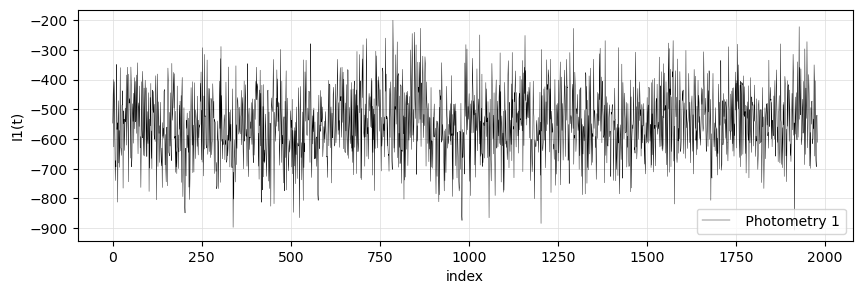

In [34]:
fig, ax = plt.subplots(1,1, figsize=(10,3))

index = list(range(0,B_raw.shape[0]))

print('Shapiro-Wilk test B:',sp.stats.shapiro(B_raw))

ax.plot(index, B_raw,color = 'black', linewidth=0.3, alpha=1., label=" Photometry 1")
ax.set_xlabel("index")
ax.set_ylabel("I1(t)")
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
ax.legend(loc=4)

plt.show()

Later, during our fitting proces, we do not have to search for the parameters $\mu_{2}$ and $\sigma_{2}$. Note that the mean value has been added to the Interferometric data $\textbf{I}$. This means that we can set the parameter $\mu_{2} = 0$. Again an MCMC algorith can show the posteriror distribution of $\mu_{2}$ and $\sigma_{2}$.

In [35]:
with pm.Model() as myModel:
    
    # define priors
    mu = pm.Uniform('mu', lower=min(B_raw), upper=max(B_raw))
    sigma = pm.Uniform('sigma', lower=0, upper=np.abs(np.quantile(B_raw,0.95) - np.quantile(B_raw,0.05)))

    # define likelihood
    y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=B_raw)

    trace = pm.sample(4000, chains=4, cores=4,target_accept = 0.95 ,return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 4 seconds.


In [36]:
az.summary(trace, var_names=['mu', 'sigma'], hdi_prob=0.95, round_to=5)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,-547.38644,2.57623,-552.25569,-542.18814,0.02571,0.01818,10018.45733,8387.03657,1.00044
sigma,111.52259,1.80916,108.00128,115.02207,0.01765,0.01248,10497.19326,8769.25944,1.00024


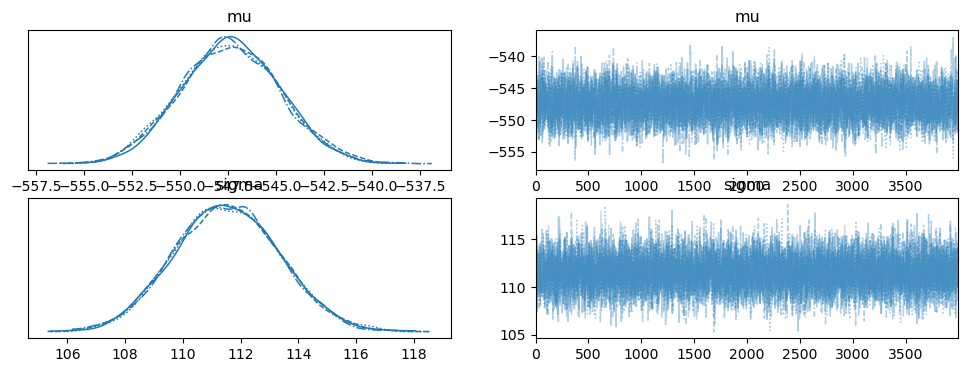

In [37]:
ax = az.plot_trace(trace, var_names=['mu','sigma'])

## Fitting the PDF function

Let us take a look at which are the searched parameters and which not in our pdf function. 

- **known values**
    - $I_{1}$ =  mean of $I_{1}$
    - $I_{2}$ =  mean of $I_{2}$
    - $\mu_{2}$ = 0.0
    - $\sigma_{2}$ = square root of the variance of B
    - $\alpha$ = mean of PCPHSTD
- **Unknown values**
    - Null N
    - $\mu_{1}$
    - $\sigma_{1}$



In orde to perform a fit of the data we will need a residual function, which is going to be minimized.

In [38]:
I_norm,numbins,I_norm_hist_bins_centers,I_norm_hist,I_norm_sigma,alpha,I1_mean,I2_mean,sigma2 = preprocess(1)
Int_lambd, tau_max_lambd,tau_min_lambd = Fill_in_known(Int_sym_raw,alpha,I1_mean,I2_mean,0.0,sigma2)


In [39]:
def residual(pars):
    """
    Returns the weighted residual.
    """
    vals = pars.valuesdict()
    
    model_counts = Int_func(I_norm_hist_bins_centers,vals['N'],vals['mu1'],vals['sigma1'])
    
    residual = (model_counts - I_norm_hist)/(I_norm_sigma)    
    
    return residual

We calculate the values that we need for our fit. 

[[Model]]
    Model(Int_func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 42
    # data points      = 19
    # variables        = 3
    chi-square         = 3.76516786
    reduced chi-square = 0.23532299
    Akaike info crit   = -24.7542842
    Bayesian info crit = -21.9209672
[[Variables]]
    N:      -0.01048524 +/- 0.00394230 (37.60%) (init = 0.01)
    mu1:     0.24463085 +/- 0.03283244 (13.42%) (init = 0.1)
    sigma1:  0.07419873 +/- 0.01152095 (15.53%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(N, mu1)      = -0.995
    C(N, sigma1)   = 0.950
    C(mu1, sigma1) = -0.947
Figure(640x640)


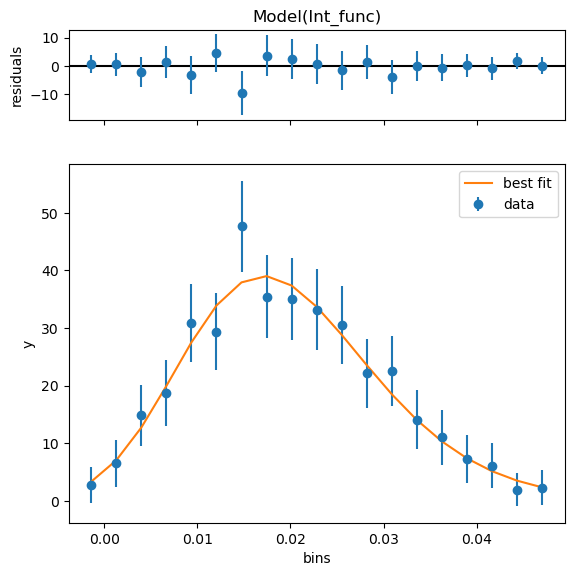

In [40]:
out_Model = lmfit.Model(Int_func,independent_vars=['bins'])

N_start, mu1_start, sigma1_start =  0.01, 0.1, 0.1

out_Model.set_param_hint('N', value=N_start)
out_Model.set_param_hint('mu1', value=mu1_start)
out_Model.set_param_hint('sigma1', value=sigma1_start,min = 0.0)

out_fit = out_Model.fit(I_norm_hist,bins = I_norm_hist_bins_centers,method='leastsq',weights=1/I_norm_sigma)

print(out_fit.fit_report())
print(out_fit.plot())

The errorbars on the parameters are not necessarily trusthworthy. We would like to find the posterior distribution of these parameters.</br> This is done via a build in MCMC algorithm in lmfit called emcee. Here is an example of how it is used</br> https://lmfit.github.io/lmfit-py/fitting.html#minimizer-emcee-calculating-the-posterior-probability-distribution-of-parameters </br> Note that running this takes a long time. For the code below it takes around 30 minutes.

In [41]:
# emcee_params = out_fit.params.copy()
# emcee = lmfit.minimize(residual, method='emcee', nan_policy='omit',burn=50, steps=200, thin=30, params=emcee_params, is_weighted=True, progress=True)

In [42]:
# emcee_plot = corner.corner(emcee.flatchain, labels=emcee.var_names)
# p = ['N','sigma1','mu1']
# for name in p:
#     quantiles = np.percentile(emcee.flatchain[name],
#                               [2.275, 15.865, 50, 84.135, 97.275])
#     median = quantiles[2]
#     err_m2 = quantiles[0] - median
#     err_m1 = quantiles[1] - median
#     err_p1 = quantiles[3] - median
#     err_p2 = quantiles[4] - median
#     fmt = '  {:5s}   {:8.4f} {:8.4f} {:8.4f} {:8.4f} {:8.4f}'.format
#     print(fmt(name, err_m2, err_m1, median, err_p1, err_p2))

We can see on the figures above that the posterior distribution of the Null is indeed asymmetrical.The errorbars that we retrieve with the emcee method are thus more trustworthy. </br>Note that ideally the MCMC method has to be run for longer chains (more steps in the emcee function). This is however not possible on a large scale since the run time would be to large. </br>

# Fitting the PDF function and calculating the error bars for all data. 

Above we fitted our function and calculated the 'real' error bars for one data point. In this part we will do this for all the data points. </br> An easy solution to make this process go faster is to paralize the code. However were not able to achieve this. An alternative is open multiple </br> (we recommend three) notebooks and run the 0-15,15-30,30-49 datapoints respectively.

In [ ]:
LeastSquare_N = []
LeastSquare_err_N = []
data_index =  np.linspace(1,49,49)

result = []

for i in data_index:
    i = int(i)
    print(i)
    
    I_norm,numbins,I_norm_hist_bins_centers,I_norm_hist,I_norm_sigma,alpha,I1_mean,I2_mean,sigma2 = preprocess(i)   
        
    Int_lambd, tau_max_lambd,tau_min_lambd = Fill_in_known(Int_sym_raw,alpha,I1_mean,I2_mean,0.0,sigma2)
    
    #PERFROM FIT
    
    out_Model = lmfit.Model(Int_func,independent_vars=['bins'])

    N_start, mu1_start, sigma1_start =  0.01, 0.1, 0.1

    out_Model.set_param_hint('N', value=N_start)
    out_Model.set_param_hint('mu1', value=mu1_start)
    out_Model.set_param_hint('sigma1', value=sigma1_start,min = 0.0)

    out_fit = out_Model.fit(I_norm_hist,bins = I_norm_hist_bins_centers,method='leastsq',weights=1/I_norm_sigma)
    print(out_fit.plot())    
    
    # Save parameters to evaluate goodness of fit
    predicted = out_fit.eval(bins=I_norm_hist_bins_centers)
    normal = sp.stats.shapiro(out_fit.residual)
    result = [normal[0],normal[1],out_fit.chisqr,out_fit.redchi]

    LeastSquare_N = np.append(LeastSquare_N,out_fit.params['N'].value)
    LeastSquare_err_N = np.append(LeastSquare_err_N,out_fit.params['N'].stderr)
        
    # PERFROM EMCEE UNCOMMENT TO RUN EMCEE       
    # emcee_params = out_fit.params.copy()
    # emcee = lmfit.minimize(residual, method='emcee', nan_policy='omit',burn=50, steps=200, thin=30, params=emcee_params, is_weighted=True, progress=True)
    
    #SAVE OUTPUT
    import pickle
    os.chdir('/lhome/simon/Documents/Nulling/Runs') 

    pickle.dump(out_fit, open("ID0" + str(i) + ".p", "wb"))
    np.save('ID0' + str(i) + '.npy',result)
    pickle.dump(emcee, open("ID0" + str(i) + "_emcee.p", "wb"))

    os.chdir('/lhome/simon/Documents/Nulling') 

Now we will upload the files and extract the needed information.

In [43]:
data_index =  np.linspace(1,49,49)

sig_low_N = []
sig_up_N = []

LeastSquare_err_N = []

mle_N = []
LeastSquare_N= []

red_chi = []
p_val = []
chi = []


for i in data_index:
    i = int(i)
    # print(i)
    
    #SELECT DATA 
    os.chdir('/lhome/simon/Documents/Nulling/Runs') 
    
    #upload files
    out_fit = pickle.load(open("ID0"+str(i)+".p", "rb"))
    emcee_result = pickle.load(open("ID0" + str(i) + "_emcee.p", "rb"))
    result = np.load('ID0' + str(i) + '.npy')
    
    #extract evaluation of lmfit
    p_val = np.append(p_val,result[1])
    red_chi = np.append(red_chi,result[3])
    chi = np.append(chi,result[2])
    
    # calculate time
    lbt_utc = np.load('lbt_utc.npy')
    cal_time = parser.parse(lbt_utc[0]).timestamp()
    clock = [float(parser.parse(i).timestamp() - cal_time) for i in lbt_utc]
    
    os.chdir('/lhome/simon/Documents/Nulling') 

    #calculate error bars of posterior distribution
    per_sig_low_N = np.percentile(emcee_result.flatchain['N'],15.865) - np.percentile(emcee_result.flatchain['N'],50)
    per_sig_high_N = np.percentile(emcee_result.flatchain['N'],84.135) - np.percentile(emcee_result.flatchain['N'],50)
    sig_low_N = np.append(sig_low_N ,per_sig_low_N)
    sig_up_N = np.append(sig_up_N ,per_sig_high_N)
    
    #extract LS result from fit
    LeastSquare_N = np.append(LeastSquare_N,out_fit.params['N'].value)
    LeastSquare_err_N = np.append(LeastSquare_err_N,out_fit.params['N'].stderr)
    
    #extract maximum likelihood estimation from posterior distribution
    highest_prob = np.argmax(emcee_result.lnprob)
    hp_loc = np.unravel_index(highest_prob, emcee_result.lnprob.shape)
    mle_N = np.append(mle_N,emcee_result.chain[hp_loc][0])
    
    # plot
    # print(out_fit.plot())    
    # print(out_fit.fit_report())
    
        
err_N = [sig_low_N,sig_up_N]
err_N = np.array(err_N)



Plot maximum likelihood estimation with emcee calculated error bars.

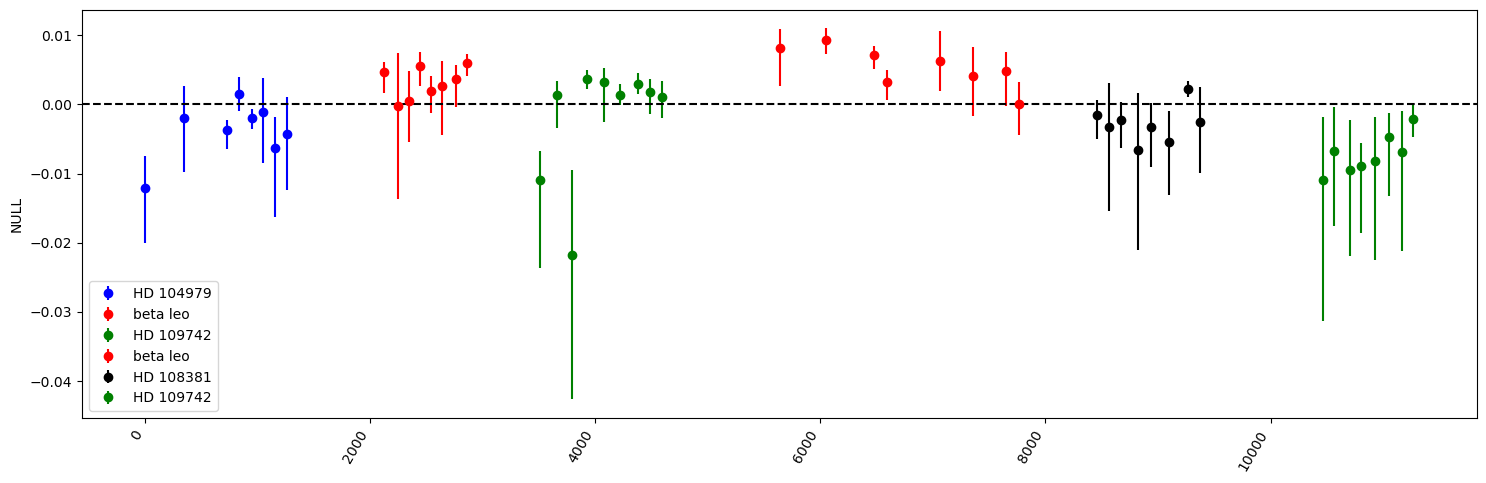

In [44]:
yas = np.array(mle_N) 
to_error = err_N
xas = np.array(clock)

fig, ax = plt.subplots(1,1, figsize=(18,6))

ax.errorbar(xas[:8],yas[:8], color = 'blue',fmt = 'o',yerr = np.abs(to_error[:,:8]),label="HD 104979")
ax.errorbar(xas[8:16],yas[8:16], color = 'red',fmt = 'o',yerr = np.abs(to_error[:,8:16]),label="beta leo")
ax.errorbar(xas[16:25],yas[16:25], color = 'green',fmt = 'o',yerr = np.abs(to_error[:,16:25]),label="HD 109742")
ax.errorbar(xas[25:33],yas[25:33], color = 'red',fmt = 'o',yerr = np.abs(to_error[:,25:33]),label="beta leo")
ax.errorbar(xas[33:41],yas[33:41], color = 'black',fmt = 'o',yerr = np.abs(to_error[:,33:41]),label="HD 108381")
ax.errorbar(xas[41:49],yas[41:49], color = 'green',fmt = 'o',yerr = np.abs(to_error[:,41:49]),label="HD 109742")
ax.set_ylabel("NULL")
plt.axhline(y=0.0, color='black', linestyle='--')
ax.legend(loc=3)

fig.autofmt_xdate(rotation=60)




Here we plot the p_value of the shapiro test of the residuals, the reduced chi_square

Text(0, 0.5, 'reduced chi square')

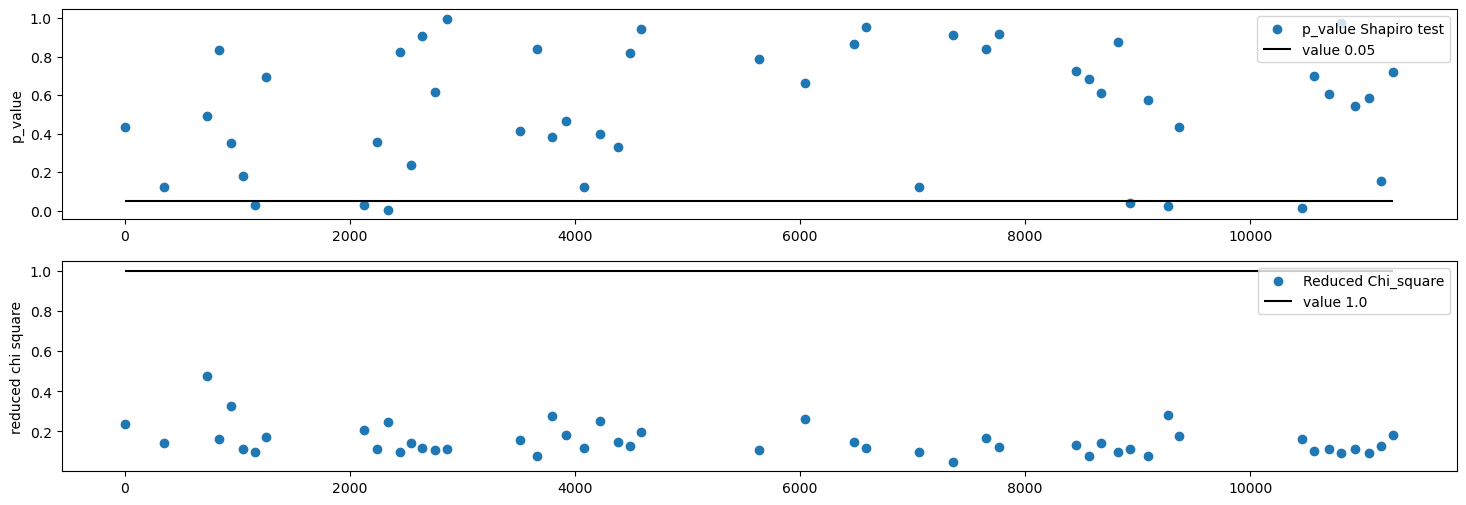

In [45]:
fig, ax = plt.subplots(2,1, figsize=(18,6))

ax[0].scatter(xas,p_val,label="p_value Shapiro test")
ax[0].hlines(y=0.05,xmin=min(xas),xmax=max(xas),color='black',label="value 0.05")
ax[0].legend(loc=1)
ax[0].set_ylabel("p_value")

ax[1].scatter(xas,red_chi,label="Reduced Chi_square")
ax[1].hlines(y=1.0,xmin=min(xas),xmax=max(xas),color='black',label="value 1.0")
ax[1].legend(loc=1)
ax[1].set_ylabel("reduced chi square")



We callibrate the found beta leo Null values, by fitting a constant value through the found Null values of the callibration stars and subtracting it from the found beta leo Null values.

In [46]:
def group(sigmas):
    '''
    Returns one errorbar (sigma) when multiple are given. 
    '''
    return 1/np.sqrt(np.sum(1/sigmas**2))

In [47]:
# Calculate one error bar of all the found error bars of the callibration stars.
err_down_cals = np.array([group(to_error[0][0:8]), group(to_error[0][16:25]), group(to_error[0][33:41]), group(to_error[0][41:])])
err_up_cals = np.array([group(to_error[1][0:8]), group(to_error[1][16:25]), group(to_error[1][33:41]), group(to_error[1][41:])])
err_cals = np.array([err_down_cals,err_up_cals])
weight_cals= np.sqrt(err_down_cals**2 + err_up_cals**2)

# Calculate the mean value of the found Null values of the callibration stars
mean_cals = [np.mean(yas[0:8]), np.mean(yas[16:25]), np.mean(yas[33:41]), np.mean(yas[41:])]

# calculate the variance of the found Null values of the callibration stars.
sig_mean_cals = np.sqrt([np.var(yas[0:8])/yas[0:8].size, 
                 np.var(yas[16:25])/yas[16:25].size,np.var(yas[33:41])/yas[33:41].size, np.var(yas[41:])/yas[41:].size])

Text(0.5, 1.0, 'Mean Null values with emcee calculated error bars')

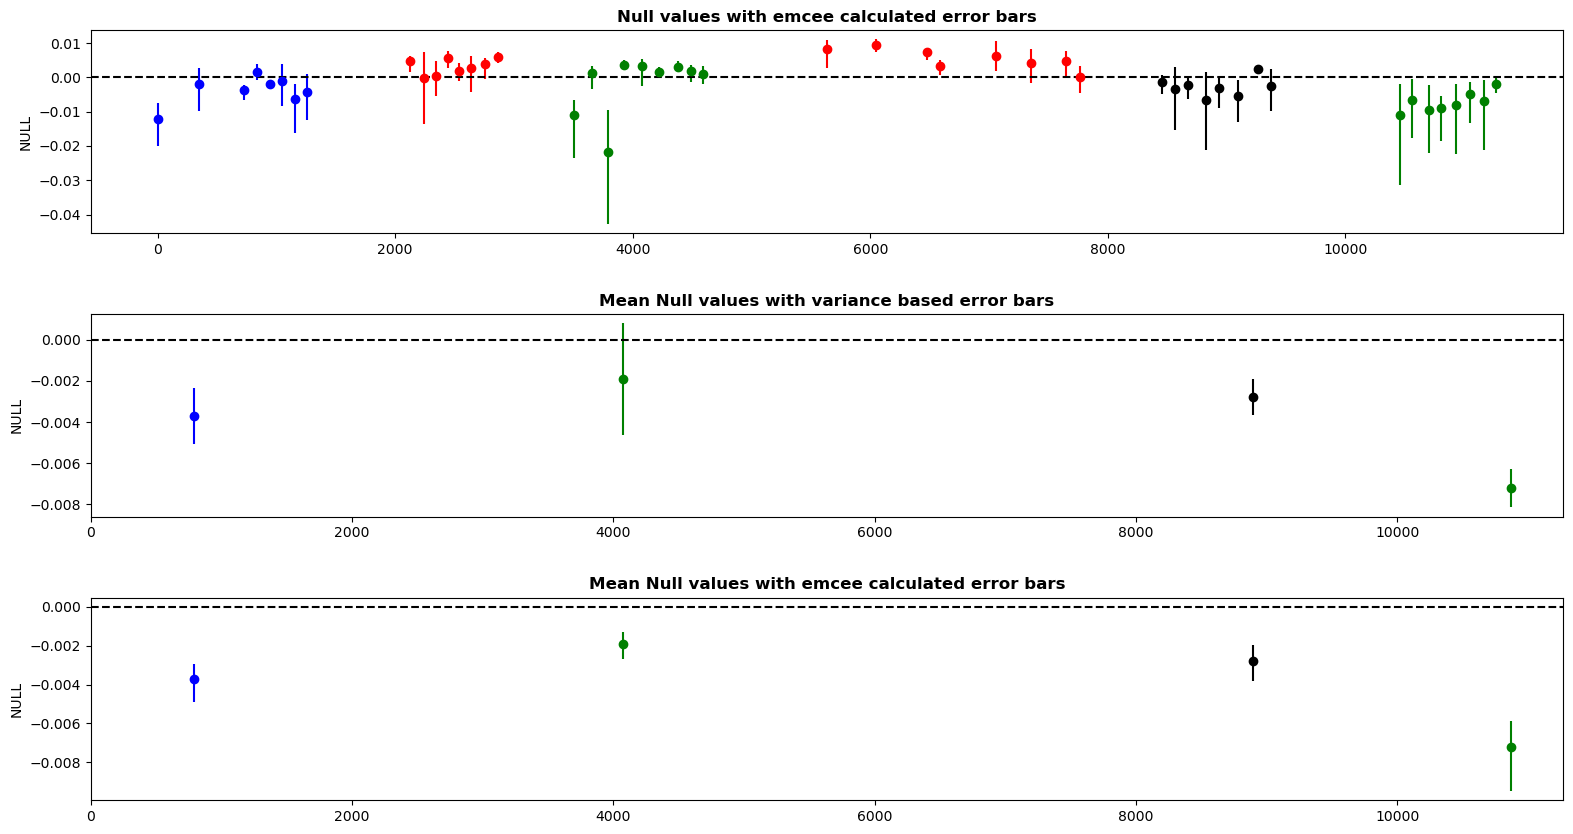

In [48]:
fig, ax = plt.subplots(3,1, figsize=(19,10))
plt.subplots_adjust(hspace=0.4)


ax[0].errorbar(xas[:8],yas[:8], color = 'blue',fmt = 'o',yerr = np.abs(to_error[:,:8]),label="HD 104979")
ax[0].errorbar(xas[8:16],yas[8:16], color = 'red',fmt = 'o',yerr = np.abs(to_error[:,8:16]),label="beta leo")
ax[0].errorbar(xas[16:25],yas[16:25], color = 'green',fmt = 'o',yerr = np.abs(to_error[:,16:25]),label="HD 109742")
ax[0].errorbar(xas[25:33],yas[25:33], color = 'red',fmt = 'o',yerr = np.abs(to_error[:,25:33]),label="beta leo")
ax[0].errorbar(xas[33:41],yas[33:41], color = 'black',fmt = 'o',yerr = np.abs(to_error[:,33:41]),label="HD 108381")
ax[0].errorbar(xas[41:],yas[41:], color = 'green',fmt = 'o',yerr = np.abs(to_error[:,41:49]),label="HD 109742")
ax[0].axhline(y=0.0, color='black', linestyle='--')
ax[0].set_ylabel("NULL")
ax[0].set_title('Null values with emcee calculated error bars',fontweight ="bold")


ax[1].errorbar([np.mean(xas[0:8])],mean_cals[0],yerr = sig_mean_cals[0],fmt = 'o',color='blue')
ax[1].errorbar([np.mean(xas[16:25])],mean_cals[1],yerr = sig_mean_cals[1],fmt = 'o',color='green')
ax[1].errorbar([np.mean(xas[33:41])],mean_cals[2],yerr = sig_mean_cals[2],fmt = 'o',color='black')
ax[1].errorbar([np.mean(xas[41:])],mean_cals[3],yerr = sig_mean_cals[3],fmt = 'o',color='green')
ax[1].set_xlim(0.0,max(clock))
ax[1].axhline(y=0.0, color='black', linestyle='--')
ax[1].set_ylabel("NULL")
ax[1].set_title('Mean Null values with variance based error bars',fontweight ="bold")


ax[2].errorbar([np.mean(xas[:8])],mean_cals[0],yerr = np.abs([[err_cals[0][0]],[err_cals[1][0]]]),fmt = 'o',color='blue')
ax[2].errorbar([np.mean(xas[16:25])],mean_cals[1],yerr = np.abs([[err_cals[0][1]],[err_cals[1][1]]]),fmt = 'o',color='green')
ax[2].errorbar([np.mean(xas[33:41])],mean_cals[2],yerr = np.abs([[err_cals[0][2]],[err_cals[1][2]]]),fmt = 'o',color='black')
ax[2].errorbar([np.mean(xas[41:])],mean_cals[3],yerr = np.abs([[err_cals[0][3]],[err_cals[1][3]]]),fmt = 'o',color='green')
ax[2].set_xlim(0.0,max(clock))
ax[2].axhline(y=0.0, color='black', linestyle='--')
ax[2].set_ylabel("NULL")
ax[2].set_title('Mean Null values with emcee calculated error bars',fontweight ="bold")



[[Model]]
    Model(myFunc)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4
    # data points      = 4
    # variables        = 1
    chi-square         = 3.97391183
    reduced chi-square = 1.32463728
    Akaike info crit   = 1.97382638
    Bayesian info crit = 1.36012074
[[Variables]]
    theta1:  0 (fixed)
    theta2: -0.00290694 +/- 7.7604e-04 (26.70%) (init = 0)
Figure(640x640)


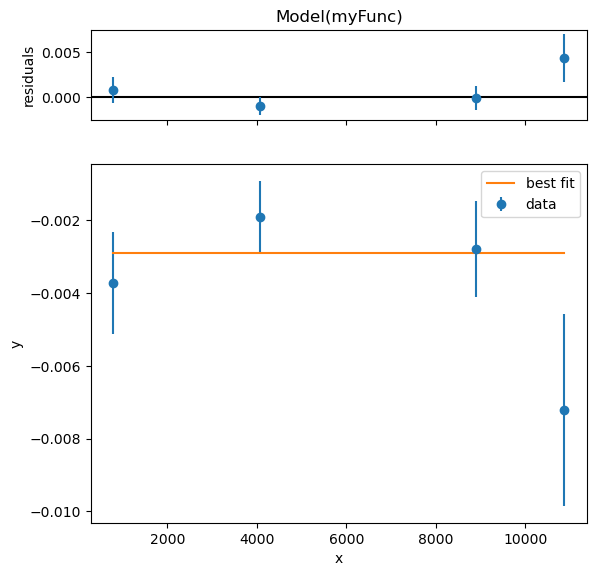

In [49]:
def myFunc(x, theta1, theta2):
    return theta1 * x + theta2

data_index =  np.linspace(1,49,49)

myModel = lmfit.Model(myFunc)
myModel.set_param_hint('theta1',value=0.0,vary=False)
myModel.set_param_hint('theta2',value=0.0)

myFit = myModel.fit(mean_cals, x=[np.mean(xas[0:8]),np.mean(xas[16:25]),np.mean(xas[33:41]),np.mean(xas[41:])],weights=1/weight_cals)
# myFit1 = myModel.fit(y_cal, x=x_cal)

print(myFit.fit_report())
print(myFit.plot())

This value can be used to correct the found Null value of the science star beta leo 

In [50]:
correction = myFit.params['theta2'].value

In [51]:
# Calculate one error bar of all the found error bars of the science star beta leo.
err_down_sci = np.array([group(to_error[0][8:16]), group(to_error[0][25:33])])
err_down_sci = np.array([group(to_error[1][8:16]), group(to_error[1][25:33])])

err_sci = np.array([err_down_cals,err_up_cals])

# Calculate the mean value of the found Null values of the science star beta leo
mean_sci = [np.mean(yas[8:16]), np.mean(yas[25:33])]
mean_sci_cor = [np.mean(yas[8:16]-correction), np.mean(yas[25:33]-correction)]

# calculate the variance of the found Null values of the callibration stars.
sig_mean_sci = np.sqrt([np.var(yas[8:16])/yas[8:16].size,np.var(yas[25:33])/yas[25:33].size])
sig_mean_sci_cor = np.sqrt([np.var(yas[8:16]-correction)/yas[8:16].size,np.var(yas[25:33]-correction)/yas[25:33].size])



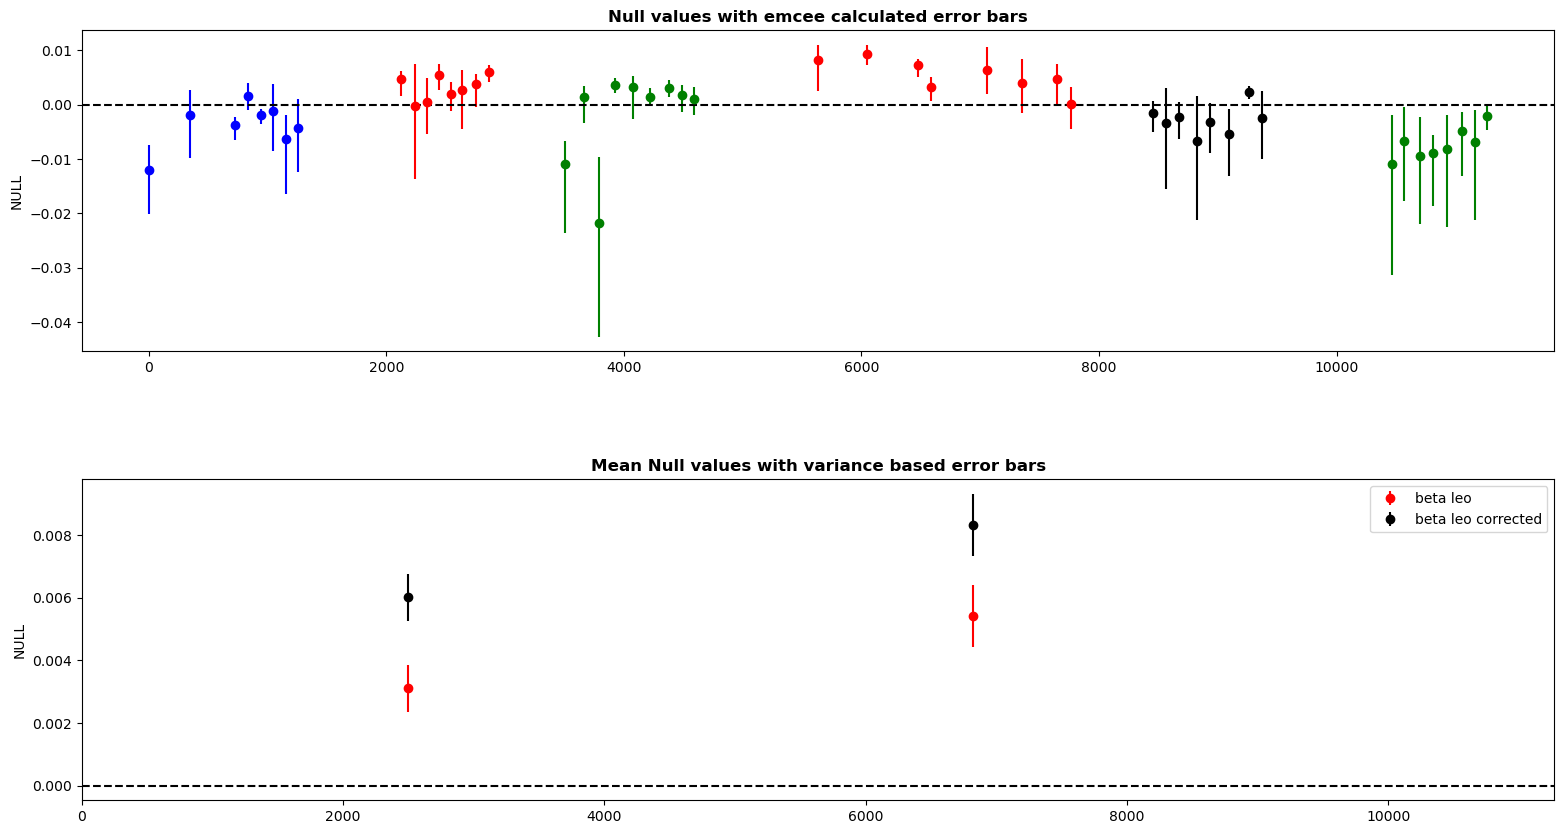

In [52]:
fig, ax = plt.subplots(2,1, figsize=(19,10))
plt.subplots_adjust(hspace=0.4)


ax[0].errorbar(xas[:8],yas[:8], color = 'blue',fmt = 'o',yerr = np.abs(to_error[:,:8]),label="HD 104979")
ax[0].errorbar(xas[8:16],yas[8:16], color = 'red',fmt = 'o',yerr = np.abs(to_error[:,8:16]),label="beta leo")
ax[0].errorbar(xas[16:25],yas[16:25], color = 'green',fmt = 'o',yerr = np.abs(to_error[:,16:25]),label="HD 109742")
ax[0].errorbar(xas[25:33],yas[25:33], color = 'red',fmt = 'o',yerr = np.abs(to_error[:,25:33]),label="beta leo")
ax[0].errorbar(xas[33:41],yas[33:41], color = 'black',fmt = 'o',yerr = np.abs(to_error[:,33:41]),label="HD 108381")
ax[0].errorbar(xas[41:],yas[41:], color = 'green',fmt = 'o',yerr = np.abs(to_error[:,41:49]),label="HD 109742")
ax[0].axhline(y=0.0, color='black', linestyle='--')
ax[0].set_ylabel("NULL")
ax[0].set_title('Null values with emcee calculated error bars',fontweight ="bold")


ax[1].errorbar([np.mean(xas[8:16])],mean_sci[0],yerr = sig_mean_sci[0],fmt = 'o',color='red',label="beta leo")
ax[1].errorbar([np.mean(xas[8:16])],mean_sci_cor[0],yerr = sig_mean_sci_cor[0],fmt = 'o',color='black',label="beta leo corrected")
ax[1].errorbar([np.mean(xas[25:33])],mean_sci[1],yerr = sig_mean_sci[1],fmt = 'o',color='red')
ax[1].errorbar([np.mean(xas[25:33])],mean_sci_cor[1],yerr = sig_mean_sci_cor[1],fmt = 'o',color='black')
ax[1].set_xlim(0.0,max(clock))
ax[1].axhline(y=0.0, color='black', linestyle='--')
ax[1].set_ylabel("NULL")
ax[1].set_title('Mean Null values with variance based error bars',fontweight ="bold")
ax[1].legend(loc=1)



SECOND METHOD

In [53]:
x_cals = np.append(np.append(xas[:8],xas[16:25]),xas[33:])
x_sci = np.append(xas[8:16],xas[25:33])

y_cals = np.append(np.append(yas[:8],yas[16:25]),yas[33:])
y_sci = np.append(yas[8:16],yas[25:33])

errors = np.sqrt(to_error[0]**2 + to_error[1]**2)
weights_cal = 1/np.append(np.append(errors[:8],errors[16:25]),errors[33:])
weights_sci = 1/np.append(errors[8:16],errors[25:33])

[[Model]]
    Model(myFunc)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 6
    # data points      = 33
    # variables        = 2
    chi-square         = 18.0386969
    reduced chi-square = 0.58189345
    Akaike info crit   = -15.9316134
    Bayesian info crit = -12.9385983
[[Variables]]
    theta1:  6.7764e-08 +/- 1.5785e-07 (232.95%) (init = 0)
    theta2:  2.0450e-04 +/- 9.7416e-04 (476.36%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(theta1, theta2) = -0.838
Figure(640x640)


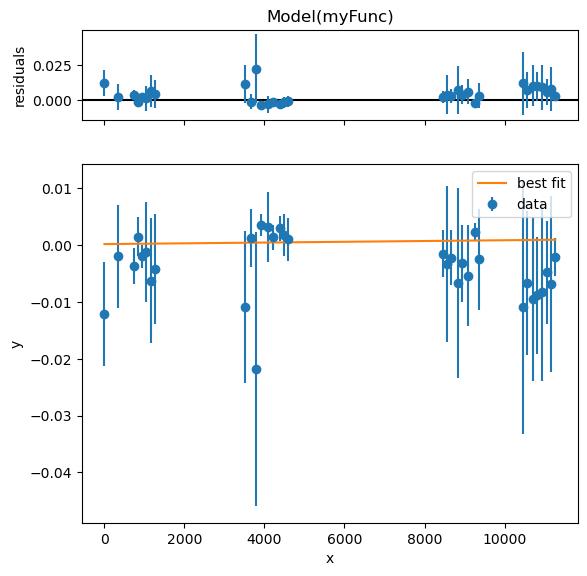

In [54]:
def myFunc(x, theta1, theta2):
    return theta1 * x + theta2

data_index =  np.linspace(1,49,49)

myModel = lmfit.Model(myFunc)
myModel.set_param_hint('theta1',value=0.0)
myModel.set_param_hint('theta2',value=0.0)

myFit = myModel.fit(y_cals, x=x_cals,weights = weights_cal)
# myFit1 = myModel.fit(y_cal, x=x_cal)

print(myFit.fit_report())
print(myFit.plot())

In [55]:
sci_correction = myFit.params['theta1']*x_sci+myFit.params['theta2']
y_sci_corrected = y_sci - sci_correction 
y_sci_corrected_w_mean = [np.average(y_sci_corrected[:8],weights=weights_sci[:8]),
                          np.average(y_sci_corrected[8:],weights=weights_sci[8:])]

err_down_sci = np.array([group(to_error[0][8:16]), group(to_error[0][25:33])])
err_down_sci = np.array([group(to_error[1][8:16]), group(to_error[1][25:33])])
err_sci = np.array([err_down_cals,err_up_cals])


Text(0.5, 1.0, 'Mean Null values with variance based error bars')

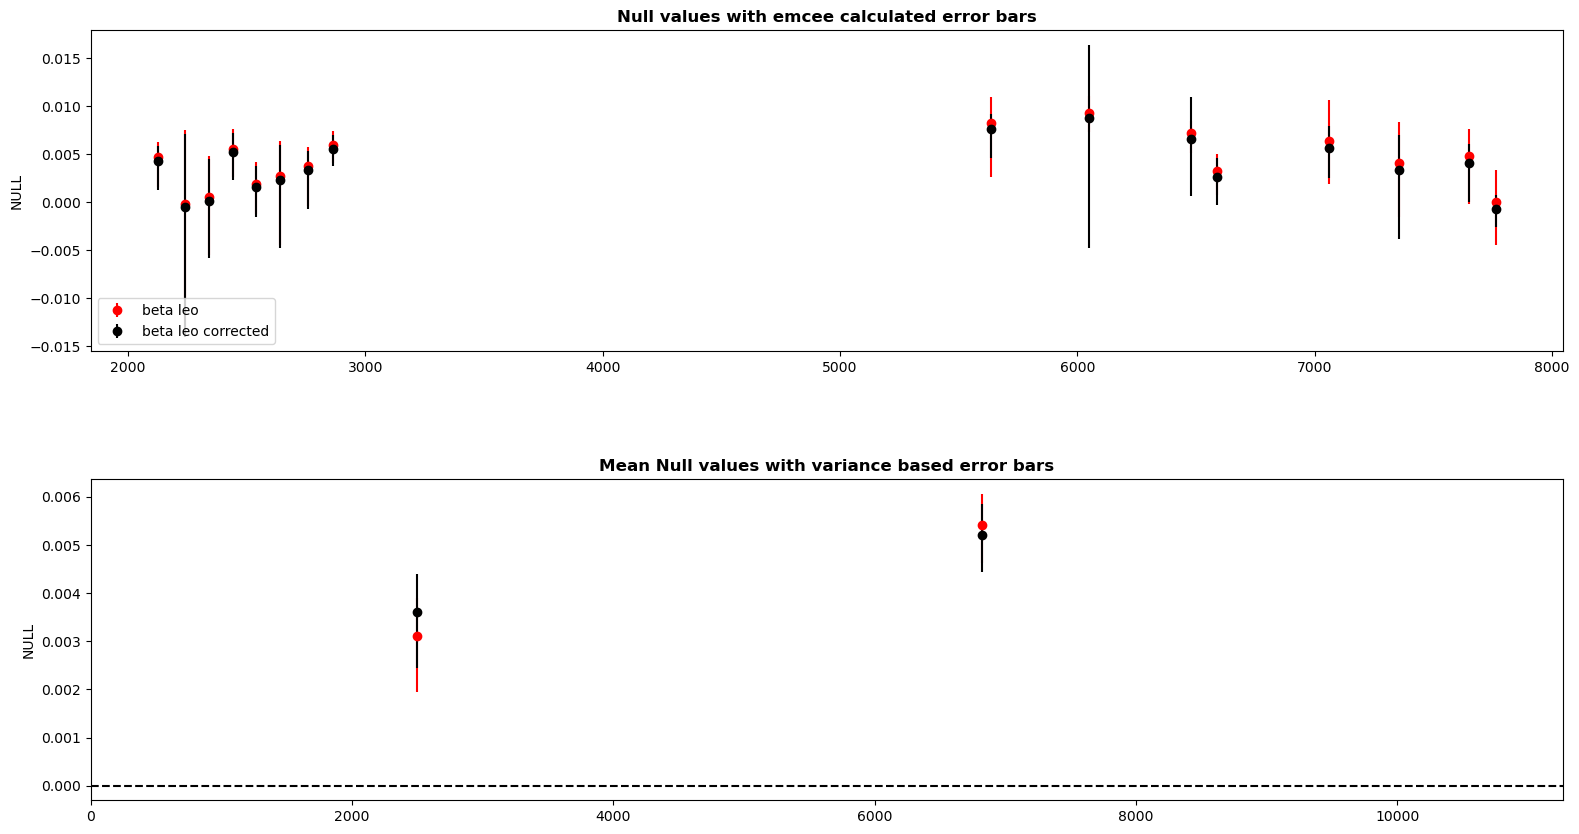

In [56]:
fig, ax = plt.subplots(2,1, figsize=(19,10))
plt.subplots_adjust(hspace=0.4)


ax[0].errorbar(xas[8:16],yas[8:16], color = 'red',fmt = 'o',yerr = np.abs(to_error[:,8:16]),label="beta leo")
ax[0].errorbar(xas[8:16],y_sci_corrected[:8], color = 'black',fmt = 'o',yerr = np.abs(to_error[:,8:16]),label="beta leo corrected")
ax[0].errorbar(xas[25:33],yas[25:33], color = 'red',fmt = 'o',yerr = np.abs(to_error[:,25:33]))
ax[0].errorbar(xas[25:33],y_sci_corrected[8:], color = 'black',fmt = 'o',yerr = np.abs(to_error[:,8:16]))
ax[0].set_ylabel("NULL")
ax[0].set_title('Null values with emcee calculated error bars',fontweight ="bold")
ax[0].legend(loc=3)


ax[1].errorbar([np.mean(xas[8:16])],mean_sci[0],yerr = np.abs([[err_sci[0][0]],[err_sci[1][0]]]),fmt = 'o',color='red',label="beta leo")
ax[1].errorbar([np.mean(xas[25:33])],mean_sci[1],yerr = np.abs([[err_sci[0][1]],[err_sci[1][1]]]),fmt = 'o',color='red')
ax[1].errorbar([np.mean(xas[8:16])],y_sci_corrected_w_mean[0],yerr = np.abs([[err_sci[0][0]],[err_sci[1][0]]]),fmt = 'o',color='black',label="beta leo corrected")
ax[1].errorbar([np.mean(xas[25:33])],y_sci_corrected_w_mean[1],yerr = np.abs([[err_sci[0][1]],[err_sci[1][1]]]),fmt = 'o',color='black')
ax[1].set_xlim(0.0,max(clock))
ax[1].axhline(y=0.0, color='black', linestyle='--')
ax[1].set_ylabel("NULL")
ax[1].set_title('Mean Null values with variance based error bars',fontweight ="bold")




In [58]:
print(y_sci_corrected_w_mean[0],err_sci[0][0],err_sci[1][0])
print(y_sci_corrected_w_mean[1],err_sci[1][0],err_sci[1][1])

0.003607292228321364 0.0011573275825888575 0.0007985141017375344
0.005206472539630494 0.0007985141017375344 0.0006486610254434389
